# Defines and general functions

In [33]:
import os
import time
import sys
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt


def print_status(message : str):
    print("[Status]: ",message)

def print_info(message : str):
    print("[Info]: ",message)

# Defining and loading the dataset

[Status]:  Defining dataset directory
[Info]:  dataset_dir set to: /home/frank/Documents/Git/Final_Embbeded_Group6/CNN/src/getimages/imgs
[Info]:  num of images: 910
[Status]:  Loading dataset images
[Info]:  Images have dims: [240, 320]
[Status]:  Creating dataset from images
Found 910 files belonging to 2 classes.
Using 728 files for training.
Found 910 files belonging to 2 classes.
Using 182 files for validation.
[Info]:  Class names found: ['cross', 'flathead']
[Status]:  Visualizing dataset


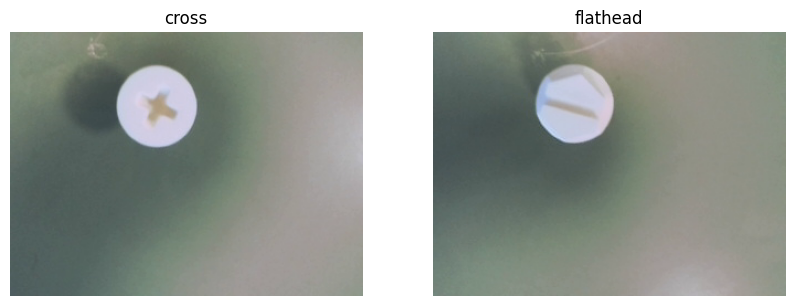

[Info]:  One traning data batch has image shape (32, 240, 320, 3)
[Info]:  One traning data batch has label shape (32,)


In [34]:
print_status("Defining dataset directory")
args = sys.argv[1:]
USE_DEFAULT_IMAGEPATH = True
if USE_DEFAULT_IMAGEPATH:
    dataset_dir = "/home/frank/Documents/Git/Final_Embbeded_Group6/CNN/src/getimages/imgs"
else:
    if len(args) == 2 and args[0] == '-image_path':
        dataset_dir = str(args[1])	
    else:
        dataset_dir = input("Write path to images:")
print_info(f"dataset_dir set to: {dataset_dir}")
data_dir = pathlib.Path(dataset_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print_info(f"num of images: {image_count}")

print_status("Loading dataset images")

image_types = ["cross", "flathead"]
image_files = {}
image_dims = []
for type in image_types:
    image_files[type] = list(data_dir.glob(type + '/*'))
for type in image_types:
    image = PIL.Image.open(str(image_files[type][0]))
    if image_dims != []:
        assert [image.height, image.width] == image_dims, f"Image types does not have the same dimensions!\n {type} has {[image.height, image.width]}, others have {image_dims}"
    else:
        image_dims = [image.height, image.width] 
    # image.show()

# input("Press the <ENTER> key to continue...")

print_info(f"Images have dims: {image_dims}")
print_status("Creating dataset from images")

batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=image_dims,
batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=image_dims,
batch_size=batch_size)

class_names = train_ds.class_names
print_info(f"Class names found: {class_names}")

print_status("Visualizing dataset")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # print(labels)
    used = []
    subplot_dims = int(np.ceil(np.sqrt(len(class_names))))
    for i, label in enumerate(labels[:-1]):
        # print(i, labels[i].numpy().astype("uint8"))
        if labels[i].numpy().astype("uint8") not in used:
            ax = plt.subplot(subplot_dims, subplot_dims, labels[i].numpy().astype("uint8") + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            used.append(labels[i].numpy().astype("uint8"))
plt.show()


for image_batch, labels_batch in train_ds:
    print_info(f"One traning data batch has image shape {image_batch.shape}")
    print_info(f"One traning data batch has label shape {labels_batch.shape}")
    break


# Optimization of dataset

In [35]:

print_status("Normalizing RGB values from [0, 255] to [0, 1]")
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print_info(f"Example result: {np.min(first_image), np.max(first_image)}")

print_status("Enabling caching and prefetching of dataset for traning and validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

[Status]:  Normalizing RGB values from [0, 255] to [0, 1]
[Info]:  Example result: (0.07450981, 1.0)
[Status]:  Enabling caching and prefetching of dataset for traning and validation


# Model definition

In [36]:
print_status("Defining model")

num_classes = len(class_names)

model = tf.keras.Sequential([
tf.keras.layers.Rescaling(1./255),
tf.keras.layers.Conv2D(32, 3, activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Conv2D(32, 3, activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Conv2D(32, 3, activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(num_classes)
])

print_status("Configuring model")

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

[Status]:  Defining model
[Status]:  Configuring model


# Model fitting

In [37]:
print_status("Fitting model")

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


# input("Press the <ENTER> key to close the program...")


[Status]:  Fitting model
Epoch 1/3


23/23 [==============================] - 52s 2s/step - loss: 0.7962 - accuracy: 0.6003 - val_loss: 0.4910 - val_accuracy: 0.6374
Epoch 2/3
23/23 [==============================] - 46s 2s/step - loss: 0.3489 - accuracy: 0.8365 - val_loss: 0.2125 - val_accuracy: 0.8901
Epoch 3/3
23/23 [==============================] - 46s 2s/step - loss: 0.2486 - accuracy: 0.9011 - val_loss: 0.2707 - val_accuracy: 0.8626


# Summarise model

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 240, 320, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 238, 318, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 119, 159, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 117, 157, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 58, 78, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 76, 32)       

# Evaluating model

In [43]:
results = model.evaluate(val_ds)

6/6 [==============================] - 3s 566ms/step - loss: 0.2707 - accuracy: 0.8626
